In [ ]:
import os, sys
project_root = os.path.abspath("../..")       # ajusta según dónde esté el notebook
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Importa tu módulo compilado
from cython_dbscan.dbscan_core import dbscan

In [4]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from src.Segmenter_v2.Segmenter import build_matrix_from_res8
import matplotlib.cm as cm

df = pd.read_parquet('../../Data/sample_jan_2021.parquet')
df.head()

,mmsi,longitude,latitude,imo,vessel_name,callsign,vessel_type,vessel_type_cargo,length,width,destination,draught,sog,cog,heading,nav_status,dt_pos_utc,vessel_type_main,H3_int_index_15,res_8
1172258,257600000.0,10.810000,55.746667,9854478,SYDSTRAUM,LAGH7,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,FI HMN > SE MMA,8.1,13.0,7.0,154.0,Under Way Using Engine,2021-01-01 00:00:50,None,644562452806690699,881f222c31fffff
1172259,257600000.0,10.810388,55.748605,9854478,SYDSTRAUM,LAGH7,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,FI HMN > SE MMA,8.1,13.4,6.6,8.0,Under Way Using Engine,2021-01-01 00:01:00,None,644562452806187528,881f222c31fffff
1172260,259372000.0,24.117868,57.007650,9118496,CHRISTINA,LIJG3,Tanker,No Additional Information,124.0,20.0,LV RIX,5.6,0.0,316.9,47.0,Moored,2021-01-01 00:01:05,Oil And Chemical Tanker,644566704828286749,881f600c35fffff
1172261,257550000.0,0.562263,54.127452,9854466,SALTSTRAUM,LAJU6,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,ANTWERP,6.0,13.7,136.3,138.0,Under Way Using Engine,2021-01-01 00:01:14,None,644459251375659225,88194464e7fffff
1172262,257550000.0,0.561667,54.126667,9854466,SALTSTRAUM,LAJU6,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,ANTWERP,6.0,13.0,136.0,0.0,Under Way Using Engine,2021-01-01 00:01:17,None,644459251374645290,88194464e7fffff


In [5]:
columnas_requeridas = {"res_8 ", "H3_int_index_15","Longitude", "Latitude"}
conteo = df.groupby('res_8')["H3_int_index_15"].count().reset_index(name ="cantidad de puntos")
res8_top= conteo.sort_values("cantidad de puntos", ascending=False).iloc[0]["res_8"]
# Filtrar todos los puntos de esa celda
df_filtrado = df[df["res_8"] == res8_top][["res_8", "H3_int_index_15", "latitude", "longitude"]].copy()

In [6]:
df_filtrado.shape

(1903, 4)

In [7]:
df_filtrado.head()

,res_8,H3_int_index_15,latitude,longitude
1246447,881f25d939fffff,644562705411233648,57.615135,10.618733
1246449,881f25d939fffff,644562705411213382,57.615000,10.618333
1246456,881f25d939fffff,644562705411213382,57.615000,10.618333
1246468,881f25d939fffff,644562705412588900,57.616515,10.619068
1246475,881f25d939fffff,644562705412606634,57.616900,10.619000


In [8]:
data_sample = build_matrix_from_res8(df_filtrado)

In [13]:
data_sample.to_csv('Data/data_sample.csv', index=False ,single_file=True)

['/Users/martingom4/Documents/04.Archive/03.Cython_DBscan-optimized/Test/Test_v0.2/Data/data_sample.csv']

In [18]:

from sklearn.cluster import DBSCAN
# 1. Separar puntos con NaN
sin_coordenadas = data_sample[data_sample["lat"].isna() | data_sample["lon"].isna()]

# 2. Reemplazar NaN por 0 en lat/lon
data_sample_pd = data_sample.compute()
data_sample_pd[["lat", "lon"]] = data_sample_pd[["lat", "lon"]].fillna(0)

# 3. Convertir a coordenadas
coords = data_sample_pd[["lat", "lon"]].to_numpy().astype(np.float64)
coords_rad = np.radians(coords)

# 4. Aplicar DBSCAN
db = DBSCAN(eps=0.3 / 6371, min_samples=5, metric="haversine").fit(coords_rad)
data_sample_pd["cluster"] = db.labels_

# 5. Marcar los puntos que eran 0,0 como cluster -99
data_sample_pd.loc[(data_sample_pd["lat"] == 0) & (data_sample_pd["lon"] == 0), "cluster"] = -99

# 6. Exportar todo
data_sample_pd.to_csv("data_sample_with_clusters.csv", index=False)


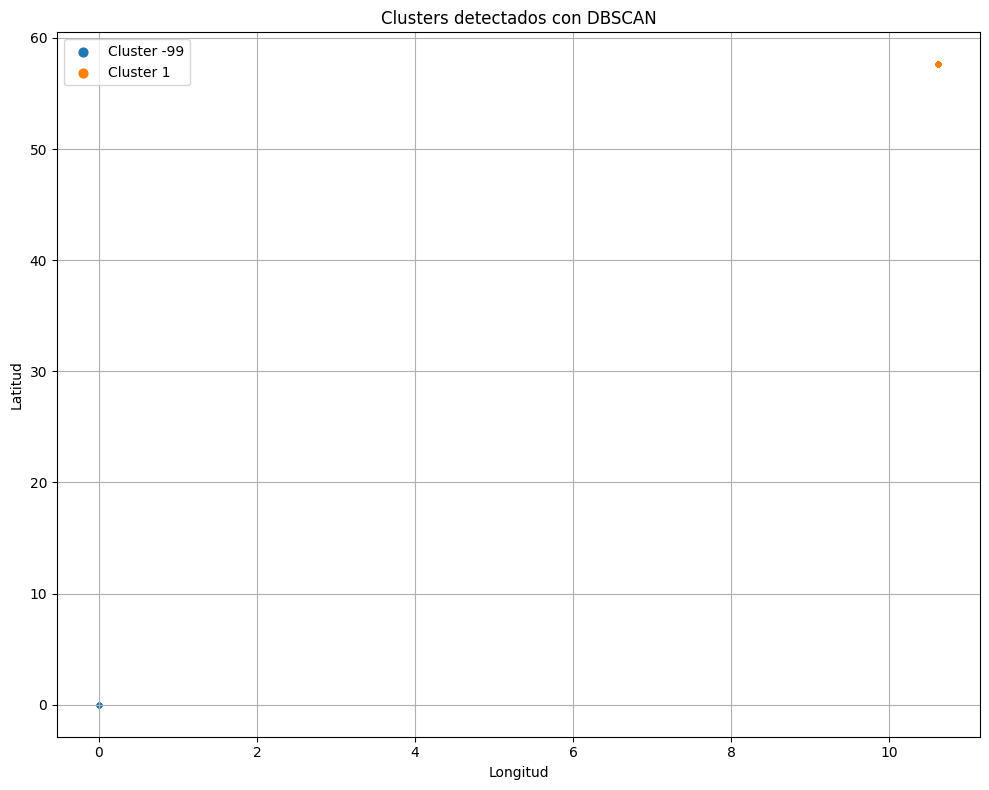

In [21]:


# Cargar resultados
df = pd.read_csv("data_sample_with_clusters.csv")

# Crear figura
plt.figure(figsize=(10, 8))

# Graficar por cluster
for cluster_id in sorted(df["cluster"].unique()):
    cluster_data = df[df["cluster"] == cluster_id]
    label = f"Cluster {cluster_id}" if cluster_id != -1 else "Ruido"
    plt.scatter(cluster_data["lon"], cluster_data["lat"], s=10, label=label)

# Personalización
plt.title("Clusters detectados con DBSCAN")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend(markerscale=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
data_sample_pd["cluster"].value_counts()

cluster
 1     1026
-99       6
Name: count, dtype: int64